## IMPORTING NECESSARY PACKAGES

In [2]:
import os
import time
import numpy as np
import pandas as pd

import datetime
import seaborn as sns

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

## Parsing and reading in nyse data
From kaggle nyse dataset

In [3]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')
def extract_price(ticker):
    '''Takes the .csv from kaggle turns it into a 3 column file with only the one stock in question'''
    dataset_ex_df = pd.read_csv('prices.csv',header = 0, index_col = 'symbol',parse_dates = [0], date_parser = parser)
    dataset_raw = dataset_ex_df.loc[ticker,['close', 'date']]
    dataset_raw.to_csv('_'+ticker+'_prices.csv')

In [5]:
dataset_gs_raw = pd.read_csv('./data_input/_GS_prices.csv').drop('symbol', axis = 1)
print(dataset_gs_raw.head(3))

        close        date
0  173.080002  2010-01-04
1  176.139999  2010-01-05
2  174.259995  2010-01-06


In [6]:
# PLOTTING MY PRICE DATASET
def plot_price(dataset):
    plt.figure(figsize=(14, 5), dpi=100)
    plt.plot(dataset['date'], dataset['close'])
    plt.xlabel('Date')
    plt.xticks([])
    plt.ylabel('USD')
    plt.title('Figure 2: Stock Price')
    plt.show()

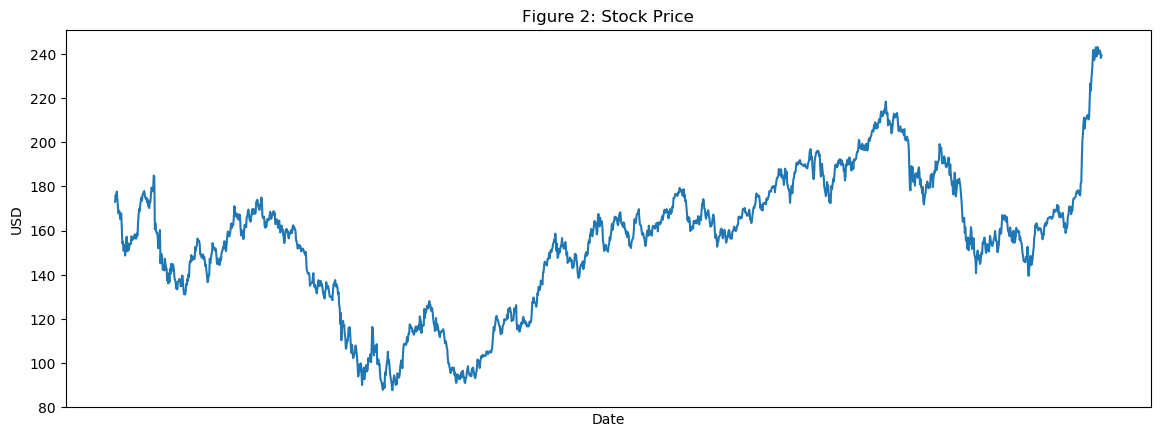

In [7]:
plot_price(dataset_gs_raw)

## Get Daily Technicals

In [8]:
def get_technicals_indic(dataset):
    '''we need to create technical indicators for the stock prices, we can add more, like RSI, later'''
    #7 and 21 day SMA
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()

    #create macd
    dataset['26ema'] = dataset['close'].ewm(span=26, adjust = False).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12, adjust = False).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    #bollinger bands
    dataset['30_Day_STD'] = dataset['close'].rolling(window=30).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['30_Day_STD'] * 2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['30_Day_STD'] * 2)
    # dataset['20sd'] = pd.stats.moments.rolling_std(dataset['close'],20)
    # dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    # dataset['upper_band'] = dataset['ma21'] - (dataset['20sd']*2)

    #create ema
    # dataset['ema'] = dataset['close'].ewm(com = 0.5).mean()

    #momentum
    dataset['momentum'] = dataset['close'].pct_change()

    return dataset

In [9]:
def plotting_TI(dataset, days_vis):
    plt.figure(figsize=(16,10), dpi=100)
    numdates = dataset.shape[0]
    vis_macd = numdates-days_vis

    dataset = dataset.iloc[-days_vis:,:]
    x_ = range(3,dataset.shape[1])
    x_ = list(dataset.index)

    plt.subplot(2,1,1)
    plt.plot(dataset['ma7'], label = 'MA 7', color = 'g', linestyle='--')
    plt.plot(dataset['ma21'], label = 'MA 21', color = 'r', linestyle='--')
    plt.plot(dataset['upper_band'], label = 'Upper Band', color = 'c')
    plt.plot(dataset['lower_band'], label = 'Lower Band', color = 'c')
    plt.plot(dataset['close'], label = 'price', color = 'b')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical Indicators for stock for the past {} days'.format(days_vis))
    plt.ylabel('USD')
    plt.xticks([])
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(dataset['MACD'], label = 'MACD', linestyle='-.')
    plt.hlines(15, vis_macd, numdates, colors = 'g', linestyle = '--')
    plt.hlines(-15, vis_macd, numdates, colors = 'g', linestyle = '--')
    plt.plot(dataset['momentum'], label = 'Momentum', color = 'r', linestyle='-')
    plt.title('MACD')
    plt.xticks([])
    plt.legend()

    plt.show()


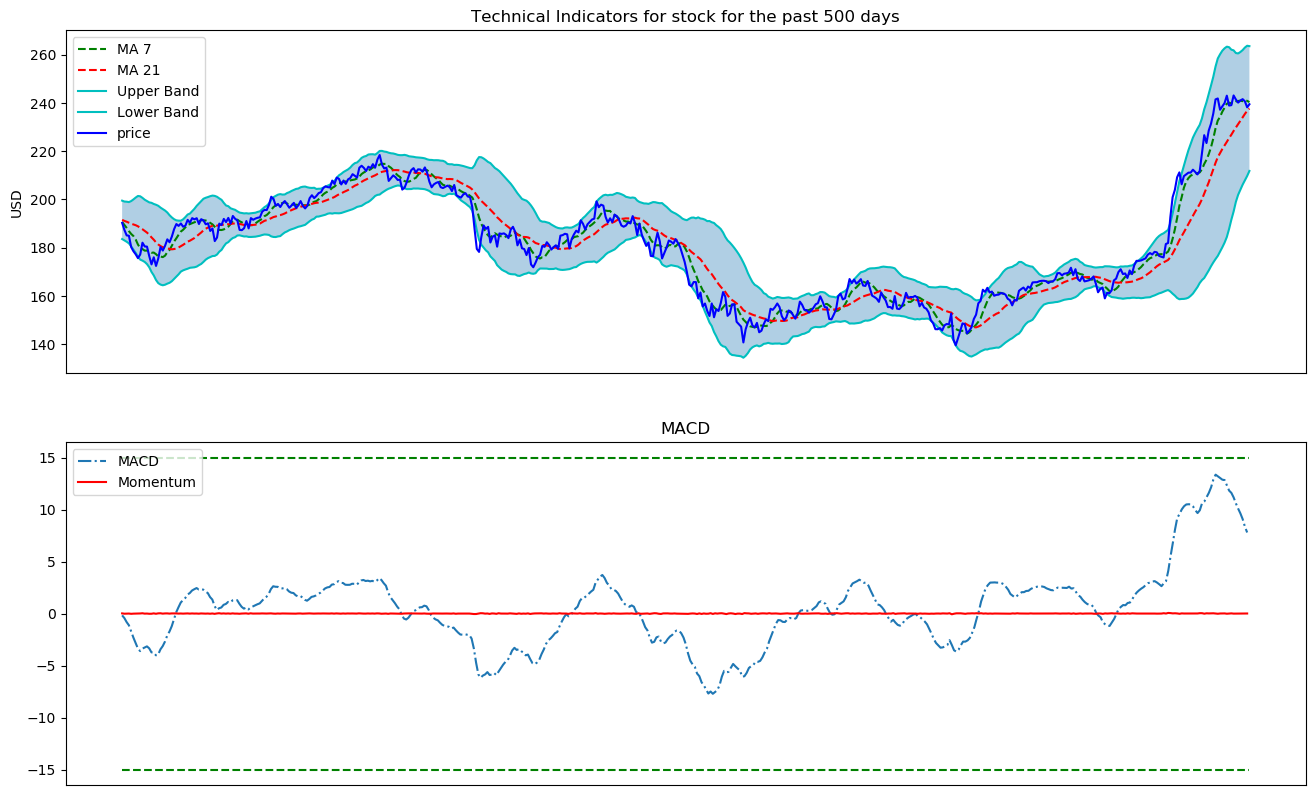

In [10]:
gs_TI = get_technicals_indic(dataset_gs_raw)
plotting_TI(gs_TI, 500)

## FEATURE ENGINEERING:
## TODO:
ELAINE AND I

In [23]:
from xgb_regressor import *

## Necessary Constants
pred_day = 1008                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

## Reading in data into dataset_stock for the stock in question
data_path = './data_input/'
dataset_stock = pd.read_csv(data_path + '_GS_prices.csv').drop('symbol', axis = 1)
add_datepart(dataset_stock, 'date', drop=False)
dataset_stock.drop('Elapsed', axis=1, inplace=True)  # don't need this column
# Change all column headings to be lower case, and remove spacing
dataset_stock.columns = [str(x).lower().replace(' ', '_') for x in dataset_stock.columns]

data_lags = add_lags(dataset_stock, N, ['close'])
data_lags.drop('date', axis = 1, inplace = True)
dataset_TI_df = get_technicals_indic(dataset_stock)
print(data_lags.head())

        close  year  month  week  day  dayofweek  dayofyear  is_month_end  \
0  173.080002  2010      1     1    4          0          4         False   
1  176.139999  2010      1     1    5          1          5         False   
2  174.259995  2010      1     1    6          2          6         False   
3  177.669998  2010      1     1    7          3          7         False   
4  174.309998  2010      1     1    8          4          8         False   

   is_month_start  is_quarter_end  ...  close_lag_1  close_lag_2  close_lag_3  \
0           False           False  ...          NaN          NaN          NaN   
1           False           False  ...   173.080002          NaN          NaN   
2           False           False  ...   176.139999   173.080002          NaN   
3           False           False  ...   174.259995   176.139999   173.080002   
4           False           False  ...   177.669998   174.259995   176.139999   

   close_lag_4  close_lag_5  close_lag_6  close_la

In [37]:
# Compute correlation
features = [
        'close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
for n in range(N,0,-1):
    features.append("close_lag_"+str(n))
        
corr_matrix = data_lags[features].corr()
corr_matrix["close"].sort_values(ascending=False)

close               1.000000
close_lag_1         0.996614
close_lag_2         0.993500
close_lag_3         0.990222
close_lag_4         0.987003
close_lag_5         0.983598
close_lag_6         0.980356
close_lag_7         0.977022
close_lag_8         0.973504
close_lag_9         0.969855
close_lag_10        0.966284
year                0.536412
month               0.044048
week                0.043351
dayofyear           0.042727
is_year_end         0.024208
is_quarter_end      0.021091
is_quarter_start    0.014159
day                -0.002789
dayofweek          -0.007659
is_month_start     -0.008003
is_month_end       -0.008532
is_year_start            NaN
Name: close, dtype: float64

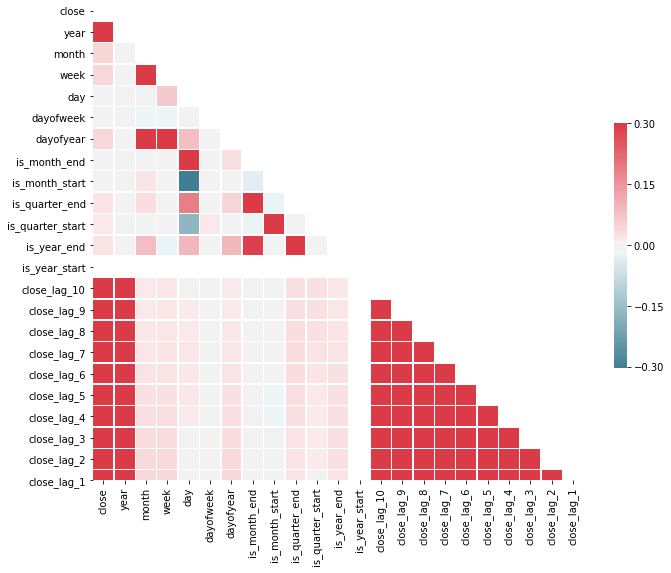

In [42]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})